In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
train_fld = r'..\Multi_Class_Classification\multi_class\train'
types = os.listdir(train_fld)
types

['Adenosis',
 'Ductal Carcinoma',
 'Fibroadenoma',
 'Lobular Carcinoma',
 'Mucinous Carcinoma',
 'Papillary Carcinoma',
 'Phyllodes Tumor',
 'Tubular Adenoma']

In [45]:
df=pd.read_csv(r'..\Data_Info\image_data_preprocessed.csv')

In [48]:
df

,Unnamed: 0,path_to_image,Benign or Malignant,Cancer Type,Magnification,image_name
0,0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X,SOB_B_A-14-22549AB-100-011.png
1,1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X,SOB_B_A-14-22549AB-100-005.png
2,2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X,SOB_B_A-14-22549AB-100-004.png
3,3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X,SOB_B_A-14-22549AB-100-010.png
4,4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X,SOB_B_A-14-22549AB-100-006.png
...,...,...,...,...,...,...
7904,7904,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X,SOB_M_LC-14-12204-200-028.png
7905,7905,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X,SOB_M_LC-14-12204-200-029.png
7906,7906,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X,SOB_M_LC-14-12204-200-006.png
7907,7907,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X,SOB_M_LC-14-12204-200-039.png


In [69]:
df_type = df.groupby('Cancer Type').agg({'Cancer Type':'count'}).rename(columns = {'Cancer Type':'Count'})

In [79]:
df_type ['Percentage'] = df_type['Count'].apply (lambda x: (x / df_type['Count'].sum()*100).round(2))

In [77]:
df_type

,Count,Percentage
Cancer Type,,
Adenosis,444,5.61
Ductal Carcinoma,3451,43.63
Fibroadenoma,1014,12.82
Lobular Carcinoma,626,7.92
Mucinous Carcinoma,792,10.01
Papillary Carcinoma,560,7.08
Phyllodes Tumor,453,5.73
Tubular Adenoma,569,7.19


TRAIN

In [18]:
train_dic = {}
for i in types:
    ct = len(os.listdir(os.path.join(train_fld, i)))
    train_dic[i]=ct

In [24]:
total_train = 0
for val in train_dic.values():
    total_train += val

In [44]:
for i in range (len(train_dic)):
    print (f'{list(train_dic.keys())[i]}: {list(train_dic.values())[i]} images, {list(train_dic.values())[i]/total_train*100:.2f}%')

Adenosis: 311 images, 5.62%
Ductal Carcinoma: 2416 images, 43.64%
Fibroadenoma: 710 images, 12.83%
Lobular Carcinoma: 438 images, 7.91%
Mucinous Carcinoma: 554 images, 10.01%
Papillary Carcinoma: 392 images, 7.08%
Phyllodes Tumor: 317 images, 5.73%
Tubular Adenoma: 398 images, 7.19%


VALIDATION

In [80]:
val_fld = r'..\Multi_Class_Classification\multi_class\validation'

val_dic = {}
for i in types:
    ct = len(os.listdir(os.path.join(val_fld, i)))
    val_dic[i]=ct

In [83]:
total_val = 0
for val in val_dic.values():
    total_val += val

In [84]:
for i in range (len(val_dic)):
    print (f'{list(val_dic.keys())[i]}: {list(val_dic.values())[i]} images, {list(val_dic.values())[i]/total_val*100:.2f}%')

Adenosis: 67 images, 5.65%
Ductal Carcinoma: 517 images, 43.59%
Fibroadenoma: 152 images, 12.82%
Lobular Carcinoma: 94 images, 7.93%
Mucinous Carcinoma: 119 images, 10.03%
Papillary Carcinoma: 84 images, 7.08%
Phyllodes Tumor: 68 images, 5.73%
Tubular Adenoma: 85 images, 7.17%


Validation Datagen

In [90]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [91]:
val_dir = r'..\Multi_Class_Classification\multi_class\validation'
val_generator = val_datagen.flow_from_directory( 
    val_dir,           
    target_size=(150,150), 
    batch_size=20,  
    class_mode='categorical',
    shuffle = False 
)

Found 1186 images belonging to 8 classes.


### Model Training ###
---

Baseline

In [85]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [87]:
train_dir = r'..\Multi_Class_Classification\multi_class\train'
train_generator = train_datagen.flow_from_directory( 
    train_dir,         
    target_size=(150,150), 
    batch_size=20,  
    class_mode='categorical')

Found 5536 images belonging to 8 classes.


In [94]:
train_generator.class_indices

{'Adenosis': 0,
 'Ductal Carcinoma': 1,
 'Fibroadenoma': 2,
 'Lobular Carcinoma': 3,
 'Mucinous Carcinoma': 4,
 'Papillary Carcinoma': 5,
 'Phyllodes Tumor': 6,
 'Tubular Adenoma': 7}

In [95]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 8)


In [92]:
model_base = models.Sequential()
model_base.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model_base.add(layers.MaxPooling2D(2,2))
model_base.add(layers.Conv2D(64, (3,3), activation='relu'))
model_base.add(layers.MaxPooling2D(2,2))
model_base.add(layers.Conv2D(128, (3,3), activation='relu'))
model_base.add(layers.MaxPooling2D(2,2))
model_base.add(layers.Flatten())
model_base.add(layers.Dense(512, activation='relu'))
model_base.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,037,768 (72.62 MB)

 Trainable params: 19,037,768 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
model_base.compile (loss = 'categorical_crossentropy', 
                    optimizer = optimizers.RMSprop(learning_rate = 0.001),
                    metrics = ['accuracy', 'recall', 'precision', 'auc']) 

In [97]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=3, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_base.h5', save_best_only=True)]

In [98]:
history_base = model_base.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4058 - auc: 0.7013 - loss: 2.5097 - precision: 0.4952 - recall: 0.1298

277/277 ━━━━━━━━━━━━━━━━━━━━ 111s 393ms/step - accuracy: 0.4426 - auc: 0.7415 - loss: 1.8705 - precision: 0.5594 - recall: 0.1709 - val_accuracy: 0.4275 - val_auc: 0.7643 - val_loss: 1.6825 - val_precision: 0.7760 - val_recall: 0.1256
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.4622 - auc: 0.7892 - loss: 1.6125 - precision: 0.6486 - recall: 0.2260

277/277 ━━━━━━━━━━━━━━━━━━━━ 166s 600ms/step - accuracy: 0.4769 - auc: 0.8028 - loss: 1.5727 - precision: 0.6500 - recall: 0.2442 - val_accuracy: 0.4806 - val_auc: 0.8222 - val_loss: 1.5011 - val_precision: 0.7601 - val_recall: 0.2538
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4826 - auc: 0.8203 - loss: 1.5250 - precision: 0.6331 - recall: 0.2493

277/277 ━━━━━━━━━━━━━━━━━━━━ 258s 932ms/step - accuracy: 0.4966 - auc: 0.8308 - loss: 1.4821 - precision: 0.6489 - recall: 0.2787 - val_accuracy: 0.5531 - val_auc: 0.8815 - val_loss: 1.3167 - val_precision: 0.7467 - val_recall: 0.2884
Epoch 4/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.5150 - auc: 0.8499 - loss: 1.4067 - precision: 0.6700 - recall: 0.3273

277/277 ━━━━━━━━━━━━━━━━━━━━ 261s 943ms/step - accuracy: 0.5139 - auc: 0.8520 - loss: 1.4005 - precision: 0.6741 - recall: 0.3311 - val_accuracy: 0.5430 - val_auc: 0.8772 - val_loss: 1.2931 - val_precision: 0.7193 - val_recall: 0.3457
Epoch 5/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.5430 - auc: 0.8671 - loss: 1.3351 - precision: 0.6804 - recall: 0.3533

277/277 ━━━━━━━━━━━━━━━━━━━━ 256s 923ms/step - accuracy: 0.5343 - auc: 0.8680 - loss: 1.3346 - precision: 0.6735 - recall: 0.3562 - val_accuracy: 0.5734 - val_auc: 0.8923 - val_loss: 1.2670 - val_precision: 0.8194 - val_recall: 0.2487
Epoch 6/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5596 - auc: 0.8846 - loss: 1.2559 - precision: 0.6851 - recall: 0.3830

277/277 ━━━━━━━━━━━━━━━━━━━━ 253s 912ms/step - accuracy: 0.5602 - auc: 0.8849 - loss: 1.2541 - precision: 0.6837 - recall: 0.3846 - val_accuracy: 0.5902 - val_auc: 0.8975 - val_loss: 1.1907 - val_precision: 0.6966 - val_recall: 0.4317
Epoch 7/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 261s 941ms/step - accuracy: 0.5900 - auc: 0.9054 - loss: 1.1435 - precision: 0.7136 - recall: 0.4370 - val_accuracy: 0.5388 - val_auc: 0.8907 - val_loss: 1.2519 - val_precision: 0.6297 - val_recall: 0.4503
Epoch 8/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 250s 902ms/step - accuracy: 0.6261 - auc: 0.9203 - loss: 1.0515 - precision: 0.7242 - recall: 0.4995 - val_accuracy: 0.5784 - val_auc: 0.8981 - val_loss: 1.2087 - val_precision: 0.6778 - val_recall: 0.4949
Epoch 9/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 227s 820ms/step - accuracy: 0.6674 - auc: 0.9414 - loss: 0.9020 - precision: 0.7486 - recall: 0.5676 - val_accuracy: 0.5379 - val_auc: 0.8903 - val_loss: 1.2927 - val_precision: 0.6191 - val_recall: 0.4536


### Class Weights Models to counter Imbalance ###
---

In [99]:
from sklearn.utils.class_weight import compute_class_weight

In [103]:
classes = list(train_generator.class_indices.keys())
num_classes = len(classes)
labels = train_generator.classes

In [101]:
classes

['Adenosis',
 'Ductal Carcinoma',
 'Fibroadenoma',
 'Lobular Carcinoma',
 'Mucinous Carcinoma',
 'Papillary Carcinoma',
 'Phyllodes Tumor',
 'Tubular Adenoma']

In [102]:
num_classes

8

In [104]:
labels

array([0, 0, 0, ..., 7, 7, 7], shape=(5536,), dtype=int32)

Compute Class Weights

In [115]:
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=labels)
class_weights = dict(enumerate(class_weights))

In [116]:
print(class_weights)

{0: np.float64(2.22508038585209), 1: np.float64(0.28642384105960267), 2: np.float64(0.9746478873239437), 3: np.float64(1.5799086757990868), 4: np.float64(1.2490974729241877), 5: np.float64(1.7653061224489797), 6: np.float64(2.182965299684543), 7: np.float64(1.7386934673366834)}


In [117]:
model_clw = models.Sequential()
model_clw.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model_clw.add(layers.MaxPooling2D(2,2))
model_clw.add(layers.Conv2D(64, (3,3), activation='relu'))
model_clw.add(layers.MaxPooling2D(2,2))
model_clw.add(layers.Conv2D(128, (3,3), activation='relu'))
model_clw.add(layers.MaxPooling2D(2,2))
model_clw.add(layers.Flatten())
model_clw.add(layers.Dense(512, activation='relu'))
model_clw.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [118]:
model_clw.compile (loss = 'categorical_crossentropy', 
                    optimizer = optimizers.RMSprop(learning_rate = 0.001),
                    metrics = ['accuracy', 'recall', 'precision', 'auc']) 

In [119]:
callbacks_clw = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_clw.h5', save_best_only=True)]

In [120]:
history_clw = model_clw.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks_clw,
    class_weight = class_weights
)

Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1397 - auc: 0.5789 - loss: 2.3957 - precision: 0.1528 - recall: 0.0045

277/277 ━━━━━━━━━━━━━━━━━━━━ 115s 408ms/step - accuracy: 0.1835 - auc: 0.6143 - loss: 2.0957 - precision: 0.3515 - recall: 0.0128 - val_accuracy: 0.2622 - val_auc: 0.6957 - val_loss: 1.8749 - val_precision: 0.4035 - val_recall: 0.0194
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.2776 - auc: 0.7162 - loss: 1.8785 - precision: 0.4868 - recall: 0.0502

277/277 ━━━━━━━━━━━━━━━━━━━━ 110s 398ms/step - accuracy: 0.2883 - auc: 0.7288 - loss: 1.8511 - precision: 0.5410 - recall: 0.0643 - val_accuracy: 0.3415 - val_auc: 0.7964 - val_loss: 1.6324 - val_precision: 0.6197 - val_recall: 0.0742
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.3169 - auc: 0.7688 - loss: 1.7435 - precision: 0.6326 - recall: 0.1154

277/277 ━━━━━━━━━━━━━━━━━━━━ 248s 897ms/step - accuracy: 0.3143 - auc: 0.7730 - loss: 1.7324 - precision: 0.5950 - recall: 0.1040 - val_accuracy: 0.4477 - val_auc: 0.8433 - val_loss: 1.4605 - val_precision: 0.7358 - val_recall: 0.1855
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.3395 - auc: 0.7973 - loss: 1.6548 - precision: 0.5238 - recall: 0.1159

277/277 ━━━━━━━━━━━━━━━━━━━━ 257s 929ms/step - accuracy: 0.3394 - auc: 0.7978 - loss: 1.6404 - precision: 0.5557 - recall: 0.1324 - val_accuracy: 0.4418 - val_auc: 0.8649 - val_loss: 1.3741 - val_precision: 0.6694 - val_recall: 0.2049
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 154s 553ms/step - accuracy: 0.3916 - auc: 0.8230 - loss: 1.5549 - precision: 0.5875 - recall: 0.1832 - val_accuracy: 0.4098 - val_auc: 0.8493 - val_loss: 1.4424 - val_precision: 0.6196 - val_recall: 0.1442
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 263s 948ms/step - accuracy: 0.4451 - auc: 0.8559 - loss: 1.3859 - precision: 0.6040 - recall: 0.2576 - val_accuracy: 0.3702 - val_auc: 0.8403 - val_loss: 1.4978 - val_precision: 0.4577 - val_recall: 0.1914
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 270s 976ms/step - accuracy: 0.5112 - auc: 0.8879 - loss: 1.1862 - precision: 0.6438 - recall: 0.3533 - val_accuracy: 0.4469 - val_auc: 0.8671 - val_loss: 1.4382 - val_precision: 0.5246 - val_recall: 0.3415
Epoch 8/20
277/277 ━━━━━━━━

Model is underfitting, not learning the paters. Next step will be to try to change the input size and improve the network topology.

In [131]:
train_dir = r'..\Multi_Class_Classification\multi_class\train'
train_generator_2 = train_datagen.flow_from_directory( 
    train_dir,         
    target_size=(224,224), 
    batch_size=32,  
    class_mode='categorical')

Found 5536 images belonging to 8 classes.


In [156]:
val_dir = r'..\Multi_Class_Classification\multi_class\validation'
val_generator_2 = val_datagen.flow_from_directory( 
    val_dir,           
    target_size=(224,224), 
    batch_size=20,  
    class_mode='categorical',
    shuffle = False 
)

Found 1186 images belonging to 8 classes.


In [133]:
model_clw_s = models.Sequential()
model_clw_s.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_clw_s.add(layers.MaxPooling2D(2,2))
model_clw_s.add(layers.Conv2D(64, (3,3), activation='relu'))
model_clw_s.add(layers.MaxPooling2D(2,2))
model_clw_s.add(layers.Conv2D(128, (3,3), activation='relu'))
model_clw_s.add(layers.MaxPooling2D(2,2))
model_clw_s.add(layers.Conv2D(256, (3,3), activation='relu'))
model_clw_s.add(layers.MaxPooling2D(2,2))
model_clw_s.add(layers.BatchNormalization())
model_clw_s.add(layers.Flatten())
model_clw_s.add(layers.Dense(512, activation='relu'))
model_clw_s.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
model_clw_s.compile (loss = 'categorical_crossentropy', 
                    optimizer = optimizers.RMSprop(learning_rate = 0.001),
                    metrics = ['accuracy', 'recall', 'precision', 'auc']) 

In [135]:
callbacks_clw_s = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_clw_s.h5', save_best_only=True)]

In [136]:
history_clw_s = model_clw_s.fit(
    train_generator_2,
    steps_per_epoch=len(train_generator_2),
    epochs=20,
    validation_data=val_generator_2,
    validation_steps=len(val_generator_2),
    callbacks=callbacks_clw_s,
    class_weight = class_weights
)

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.2232 - auc: 0.6479 - loss: 4.4245 - precision: 0.2871 - recall: 0.0600

173/173 ━━━━━━━━━━━━━━━━━━━━ 146s 833ms/step - accuracy: 0.2654 - auc: 0.7026 - loss: 2.4783 - precision: 0.3841 - recall: 0.0620 - val_accuracy: 0.4359 - val_auc: 0.7179 - val_loss: 1.8904 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 151s 873ms/step - accuracy: 0.3349 - auc: 0.7853 - loss: 1.6752 - precision: 0.5365 - recall: 0.1302 - val_accuracy: 0.1282 - val_auc: 0.4191 - val_loss: 3.3078 - val_precision: 0.4524 - val_recall: 0.0160
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.3640 - auc: 0.8171 - loss: 1.5560 - precision: 0.5595 - recall: 0.1700 - val_accuracy: 0.0843 - val_auc: 0.4397 - val_loss: 3.6636 - val_precision: 0.1429 - val_recall: 0.0177
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.4116 - auc: 0.8433 - loss: 1.4259 - precision: 0.6003 - recall: 0.2275

173/173 ━━━━━━━━━━━━━━━━━━━━ 149s 859ms/step - accuracy: 0.4129 - auc: 0.8436 - loss: 1.4338 - precision: 0.5970 - recall: 0.2290 - val_accuracy: 0.3820 - val_auc: 0.8069 - val_loss: 1.7695 - val_precision: 0.5113 - val_recall: 0.2470
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.4839 - auc: 0.8770 - loss: 1.2673 - precision: 0.6260 - recall: 0.3087 - val_accuracy: 0.2504 - val_auc: 0.6844 - val_loss: 8.2628 - val_precision: 0.2515 - val_recall: 0.2470
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.5477 - auc: 0.9014 - loss: 1.1139 - precision: 0.6686 - recall: 0.3936 - val_accuracy: 0.4351 - val_auc: 0.6918 - val_loss: 8.2736 - val_precision: 0.4351 - val_recall: 0.4351


Training is improving but model is not generalizing well. Next step will be adding a dropout layer plus L2 Regularization.

In [137]:
from tensorflow.keras import regularizers

In [140]:
model_clw_dr = models.Sequential()
model_clw_dr.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_clw_dr.add(layers.MaxPooling2D(2,2))
model_clw_dr.add(layers.Conv2D(64, (3,3), activation='relu'))
model_clw_dr.add(layers.MaxPooling2D(2,2))
model_clw_dr.add(layers.Conv2D(128, (3,3), activation='relu'))
model_clw_dr.add(layers.MaxPooling2D(2,2))
model_clw_dr.add(layers.Conv2D(256, (3,3), activation='relu'))
model_clw_dr.add(layers.MaxPooling2D(2,2))
model_clw_dr.add(layers.BatchNormalization())
model_clw_dr.add(layers.Flatten())
model_clw_dr.add(layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_clw_dr.add(layers.Dropout(0.5))
model_clw_dr.add(layers.Dense(8, activation='softmax'))

In [141]:
model_clw_dr.compile (loss = 'categorical_crossentropy', 
                    optimizer = optimizers.RMSprop(learning_rate = 0.001),
                    metrics = ['accuracy', 'recall', 'precision', 'auc'])

In [142]:
callbacks_clw_dr = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=7, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_clw_dr.h5', save_best_only=True)]

In [ ]:
history_clw_dr = model_clw_dr.fit(
    train_generator_2,
    steps_per_epoch=len(train_generator_2),
    epochs=20,
    validation_data=val_generator_2,
    validation_steps=len(val_generator_2),
    callbacks=callbacks_clw_dr,
    class_weight = class_weights
)

Still not great results. Data Augmentation is the next step.

### Data Augmentation + Class Weights ###
---

In [144]:
from tensorflow.keras.models import load_model

In [173]:
model_t = models.Sequential()
model_t.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_t.add(layers.MaxPooling2D(2,2))
model_t.add(layers.Conv2D(64, (3,3), activation='relu'))
model_t.add(layers.MaxPooling2D(2,2))
model_t.add(layers.Conv2D(128, (3,3), activation='relu'))
model_t.add(layers.MaxPooling2D(2,2))
model_t.add(layers.Conv2D(256, (3,3), activation='relu'))
model_t.add(layers.MaxPooling2D(2,2))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Flatten())
model_t.add(layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_t.add(layers.Dropout(0.5))
model_t.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [174]:
model_t.compile (loss = 'categorical_crossentropy', 
                    optimizer = optimizers.Adam(learning_rate = 0.001),
                    metrics = ['accuracy', 'recall', 'precision', 'auc'])

In [166]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [167]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 5536 images belonging to 8 classes.


In [170]:
val_generator = val_datagen.flow_from_directory( 
    val_dir,           
    target_size=(224,224), 
    batch_size=32,  
    class_mode='categorical',
    shuffle = False 
)

Found 1186 images belonging to 8 classes.


In [168]:
callbacks_t = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_t.h5', save_best_only=True)]

In [175]:
history_t = model_t.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks_t,
    class_weight = class_weights
)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.2633 - auc: 0.6838 - loss: 3.1105 - precision: 0.4125 - recall: 0.0745

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.2905 - auc: 0.7321 - loss: 2.6476 - precision: 0.4952 - recall: 0.0939 - val_accuracy: 0.0953 - val_auc: 0.6499 - val_loss: 2.4167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.3304 - auc: 0.7767 - loss: 2.0295 - precision: 0.5595 - recall: 0.1154 - val_accuracy: 0.0750 - val_auc: 0.4618 - val_loss: 2.8097 - val_precision: 0.0667 - val_recall: 0.0025
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3526 - auc: 0.7945 - loss: 1.8566 - precision: 0.5779 - recall: 0.1454 - val_accuracy: 0.1138 - val_auc: 0.5749 - val_loss: 2.6475 - val_precision: 0.1486 - val_recall: 0.0590
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.3463 - auc: 0.8028 - loss: 1.7724 - precision: 0.5578 - recall: 0.1438 - val_accuracy: 0.1518 - val_auc: 0.5478 - val_loss: 4.0396 - val_precision: 0.1740 - val_recall: 0.0531
Epoch 5/20
173/173 ━━━━━━━━━━━━

173/173 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.3622 - auc: 0.8054 - loss: 1.7487 - precision: 0.5778 - recall: 0.1535 - val_accuracy: 0.3204 - val_auc: 0.7447 - val_loss: 2.3850 - val_precision: 0.3624 - val_recall: 0.2631
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.3694 - auc: 0.8176 - loss: 1.6875 - precision: 0.5697 - recall: 0.1720 - val_accuracy: 0.1762 - val_auc: 0.6801 - val_loss: 4.2659 - val_precision: 0.1765 - val_recall: 0.1737
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.3663 - auc: 0.8146 - loss: 1.7760 - precision: 0.5549 - recall: 0.1651 - val_accuracy: 0.4384 - val_auc: 0.6956 - val_loss: 5.6302 - val_precision: 0.4403 - val_recall: 0.4384
Epoch 9/20
 34/173 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.4354 - auc: 0.8397 - loss: 1.7597 - precision: 0.6030 - recall: 0.2111

KeyboardInterrupt: 

Standart techniques are not improving the model. Next step is to try transfer learning

### Transfer Learning Test ###
---

In [192]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [206]:
transfer_model = VGG16(
    weights='imagenet',        
    include_top=False,          
    input_shape=(224,224,3)    
)

In [207]:
for layer in transfer_model.layers:
    layer.trainable = False

In [199]:
transfer_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [208]:
transfer_model.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1554>

In [209]:
x = transfer_model.output           
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.3)(x)             
output = Dense(8, activation='softmax')(x) 

In [210]:
model_transfer = Model(inputs=transfer_model.input, outputs=output)

In [211]:
model_transfer.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

In [212]:
callbacks_tr = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_tr.h5', save_best_only=True)]

In [213]:
transfer_history = model_transfer.fit(
    train_generator,          
    validation_data=val_generator,
    epochs=10,                
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights,  
    callbacks=callbacks_tr)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1221 - auc: 0.4990 - loss: 2.1597 - precision: 0.0000e+00 - recall: 0.0000e+00

173/173 ━━━━━━━━━━━━━━━━━━━━ 1132s 7s/step - accuracy: 0.1543 - auc: 0.5563 - loss: 2.0740 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2664 - val_auc: 0.6757 - val_loss: 1.9642 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2111 - auc: 0.6359 - loss: 1.9719 - precision: 0.0000e+00 - recall: 0.0000e+00

173/173 ━━━━━━━━━━━━━━━━━━━━ 1523s 9s/step - accuracy: 0.2251 - auc: 0.6553 - loss: 1.9389 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3145 - val_auc: 0.7334 - val_loss: 1.8813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2448 - auc: 0.6774 - loss: 1.9213 - precision: 0.6609 - recall: 6.4265e-04

173/173 ━━━━━━━━━━━━━━━━━━━━ 1528s 9s/step - accuracy: 0.2677 - auc: 0.7003 - loss: 1.8672 - precision: 0.5455 - recall: 0.0011 - val_accuracy: 0.3364 - val_auc: 0.7459 - val_loss: 1.8360 - val_precision: 1.0000 - val_recall: 8.4317e-04
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2894 - auc: 0.7169 - loss: 1.8204 - precision: 0.6365 - recall: 0.0022

173/173 ━━━━━━━━━━━━━━━━━━━━ 1473s 9s/step - accuracy: 0.2896 - auc: 0.7212 - loss: 1.8138 - precision: 0.5926 - recall: 0.0029 - val_accuracy: 0.3651 - val_auc: 0.7845 - val_loss: 1.7560 - val_precision: 1.0000 - val_recall: 0.0025
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3059 - auc: 0.7303 - loss: 1.8000 - precision: 0.5048 - recall: 0.0049

173/173 ━━━━━━━━━━━━━━━━━━━━ 1526s 9s/step - accuracy: 0.3046 - auc: 0.7332 - loss: 1.7809 - precision: 0.5909 - recall: 0.0070 - val_accuracy: 0.3803 - val_auc: 0.7988 - val_loss: 1.7119 - val_precision: 0.7143 - val_recall: 0.0042
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3168 - auc: 0.7447 - loss: 1.7611 - precision: 0.6845 - recall: 0.0137

173/173 ━━━━━━━━━━━━━━━━━━━━ 1390s 8s/step - accuracy: 0.3161 - auc: 0.7449 - loss: 1.7547 - precision: 0.6148 - recall: 0.0135 - val_accuracy: 0.3685 - val_auc: 0.7934 - val_loss: 1.7059 - val_precision: 0.7222 - val_recall: 0.0110
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3370 - auc: 0.7534 - loss: 1.7251 - precision: 0.6585 - recall: 0.0168

173/173 ━━━━━━━━━━━━━━━━━━━━ 1476s 9s/step - accuracy: 0.3324 - auc: 0.7523 - loss: 1.7325 - precision: 0.6730 - recall: 0.0193 - val_accuracy: 0.3693 - val_auc: 0.7945 - val_loss: 1.6935 - val_precision: 0.7826 - val_recall: 0.0152
Epoch 8/10
 27/173 ━━━━━━━━━━━━━━━━━━━━ 15:44 6s/step - accuracy: 0.3569 - auc: 0.7642 - loss: 1.6224 - precision: 0.6560 - recall: 0.0231

KeyboardInterrupt: 

In [256]:
accuracy_base = history_base.history['accuracy']
val_acc_base = history_base.history ['val_accuracy']
epochs_base = range(1, len(accuracy_base)+1)

accuracy_clw = history_clw.history['accuracy']
val_acc_clw = history_clw.history ['val_accuracy']
epochs_clw = range(1, len(accuracy_clw)+1)

accuracy_clw_s = history_clw_s.history['accuracy']
val_acc_clw_s = history_clw_s.history ['val_accuracy']
epochs_clw_s = range(1, len(accuracy_clw_s)+1)

accuracy_under = transfer_under.history['accuracy']
val_acc_under = transfer_under.history ['val_accuracy']
epochs_under = range(1, len(accuracy_under)+1)


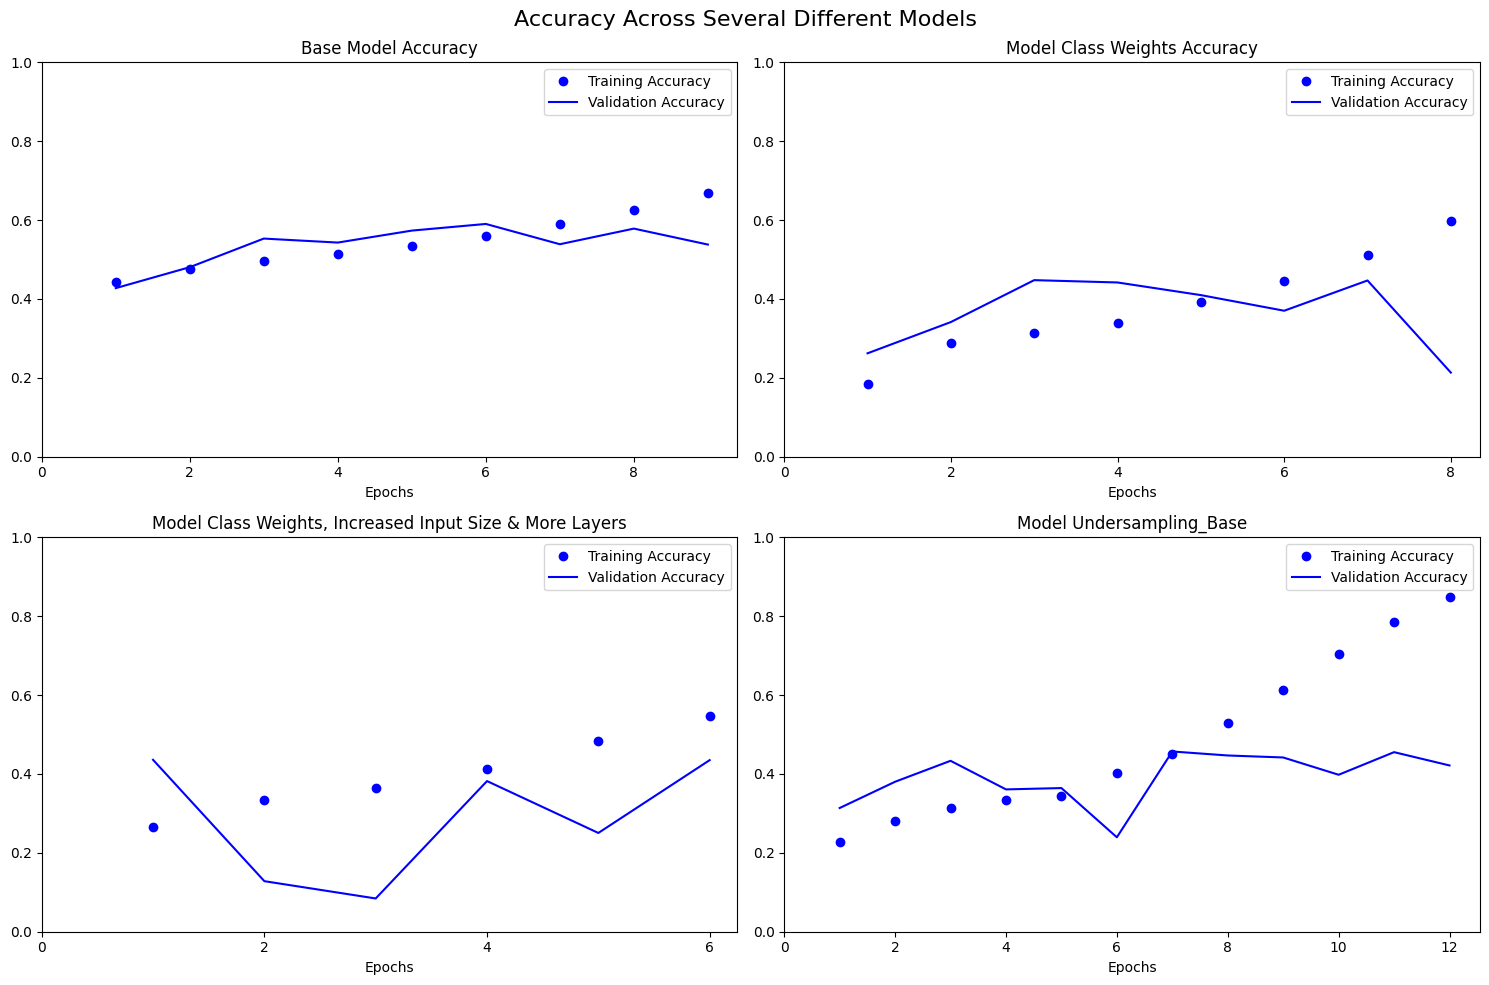

In [258]:
fig, axes = plt.subplots (nrows = 2, ncols = 2, figsize = (15,10))

axes[0,0].plot (epochs_base, accuracy_base, 'bo', label = 'Training Accuracy')
axes[0,0].plot (epochs_base, val_acc_base, 'b', label = 'Validation Accuracy')
axes[0,0].set_title ('Base Model Accuracy')
axes[0,0].set_xlabel ('Epochs')
axes[0,0].set_xticks (range(0, len(accuracy_base)+1, 2))
axes[0,0].set_ylim(0,1)
axes[0,0].legend()

axes[0,1].plot (epochs_clw, accuracy_clw, 'bo', label = 'Training Accuracy')
axes[0,1].plot (epochs_clw, val_acc_clw, 'b', label = 'Validation Accuracy')
axes[0,1].set_title ('Model Class Weights Accuracy')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_xticks (range(0, len(accuracy_clw)+1, 2))
axes[0,1].set_ylim(0,1)
axes[0,1].legend()

axes[1,0].plot (epochs_clw_s, accuracy_clw_s, 'bo', label = 'Training Accuracy')
axes[1,0].plot (epochs_clw_s, val_acc_clw_s, 'b', label = 'Validation Accuracy')
axes[1,0].set_title ('Model Class Weights, Increased Input Size & More Layers')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_xticks (range(0, len(accuracy_clw_s)+1, 2))
axes[1,0].set_ylim(0,1)
axes[1,0].legend()

axes[1,1].plot (epochs_under, accuracy_under, 'bo',  label = 'Training Accuracy')
axes[1,1].plot (epochs_under, val_acc_under, 'b',  label = 'Validation Accuracy')
axes[1,1].set_title ('Model Undersampling_Base')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_xticks (range(0, len(accuracy_under)+1, 2))
axes[1,1].set_ylim(0,1)
axes[1,1].legend()


fig.suptitle('Accuracy Across Several Different Models', fontsize=16)
plt.tight_layout()
plt.show()

In [259]:
fig.savefig("First Models Accuracy.png", dpi=300, bbox_inches='tight')

Model seems to be slightly improving after each epoch, but the increase is very small. Next step would be undersampling.

In [219]:
train_datagen_u = ImageDataGenerator(rescale = 1./255)

In [220]:
train_dir_u = r'..\Multi_Class_Classification\multi_class_undersampling\train'
train_generator_u = train_datagen_u.flow_from_directory( 
    train_dir_u,         
    target_size=(224,224), 
    batch_size=20,  
    class_mode='categorical')

Found 3830 images belonging to 8 classes.


In [221]:
val_datagen_u = ImageDataGenerator(rescale = 1./255)

In [222]:
val_dir_u = r'..\Multi_Class_Classification\multi_class_undersampling\validation'
val_generator_u = val_datagen_u.flow_from_directory( 
    val_dir_u,         
    target_size=(224,224), 
    batch_size=20,  
    class_mode='categorical')

Found 1186 images belonging to 8 classes.


In [ ]:
model_u = models.Sequential()
model_u.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_u.add(layers.MaxPooling2D(2,2))
model_u.add(layers.Conv2D(64, (3,3), activation='relu'))
model_u.add(layers.MaxPooling2D(2,2))
model_u.add(layers.Conv2D(128, (3,3), activation='relu'))
model_u.add(layers.MaxPooling2D(2,2))
model_u.add(layers.Conv2D(256, (3,3), activation='relu'))
model_u.add(layers.MaxPooling2D(2,2))
model_u.add(layers.Flatten())
model_u.add(layers.Dense(512, activation='relu'))
model_u.add(layers.Dense(8, activation='softmax'))

In [224]:
model_u.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc'])

In [226]:
callbacks_u = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_u.h5', save_best_only=True)]

In [227]:
transfer_under = model_u.fit(
    train_generator_u,          
    validation_data=val_generator_u,
    epochs=15,                
    steps_per_epoch=len(train_generator_u),
    validation_steps=len(val_generator_u), 
    callbacks=callbacks_u)

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.1870 - auc: 0.5932 - loss: 2.1832 - precision: 0.1961 - recall: 0.0077

192/192 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.2282 - auc: 0.6222 - loss: 2.0436 - precision: 0.2889 - recall: 0.0102 - val_accuracy: 0.3137 - val_auc: 0.6381 - val_loss: 1.9550 - val_precision: 0.5000 - val_recall: 0.0051
Epoch 2/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2751 - auc: 0.6777 - loss: 1.9155 - precision: 0.4037 - recall: 0.0213

192/192 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.2820 - auc: 0.6918 - loss: 1.8952 - precision: 0.4489 - recall: 0.0264 - val_accuracy: 0.3803 - val_auc: 0.7919 - val_loss: 1.6301 - val_precision: 0.8647 - val_recall: 0.0970
Epoch 3/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.3075 - auc: 0.7187 - loss: 1.8358 - precision: 0.4994 - recall: 0.0444

192/192 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.3138 - auc: 0.7279 - loss: 1.8152 - precision: 0.5173 - recall: 0.0507 - val_accuracy: 0.4334 - val_auc: 0.7932 - val_loss: 1.6274 - val_precision: 0.6736 - val_recall: 0.2715
Epoch 4/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.3329 - auc: 0.7606 - loss: 1.7363 - precision: 0.5233 - recall: 0.0705 - val_accuracy: 0.3609 - val_auc: 0.6523 - val_loss: 2.1681 - val_precision: 0.5205 - val_recall: 0.1391
Epoch 5/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3444 - auc: 0.7752 - loss: 1.6990 - precision: 0.5363 - recall: 0.0791 - val_accuracy: 0.3642 - val_auc: 0.7437 - val_loss: 1.7823 - val_precision: 0.6528 - val_recall: 0.1189
Epoch 6/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.4034 - auc: 0.8087 - loss: 1.5976 - precision: 0.5730 - recall: 0.1373 - val_accuracy: 0.2395 - val_auc: 0.6927 - val_loss: 2.0034 - val_precision: 0.3891 - val_recall: 0.0902
Epoch 7/15
192/192 ━━━━━━━━━━━━━━━━━━━━

192/192 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.4514 - auc: 0.8400 - loss: 1.4794 - precision: 0.6161 - recall: 0.2037 - val_accuracy: 0.4570 - val_auc: 0.8561 - val_loss: 1.4031 - val_precision: 0.6535 - val_recall: 0.1813
Epoch 8/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5282 - auc: 0.8792 - loss: 1.2919 - precision: 0.6853 - recall: 0.3269 - val_accuracy: 0.4469 - val_auc: 0.8283 - val_loss: 1.6305 - val_precision: 0.5498 - val_recall: 0.2934
Epoch 9/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.6120 - auc: 0.9155 - loss: 1.0890 - precision: 0.7324 - recall: 0.4546 - val_accuracy: 0.4418 - val_auc: 0.8175 - val_loss: 1.8902 - val_precision: 0.5112 - val_recall: 0.3457
Epoch 10/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7044 - auc: 0.9494 - loss: 0.8385 - precision: 0.7927 - recall: 0.6050 - val_accuracy: 0.3980 - val_auc: 0.7861 - val_loss: 2.2164 - val_precision: 0.4419 - val_recall: 0.3272
Epoch 11/15
192/192 ━━━━━━━━━━━━━━━━━━

With Undersampling, the model is performing well on training data but its not generalizing well, suggesting overfitiing. NExt steps will be to add regularization and dropou.

In [230]:
model_u_dr = models.Sequential()
model_u_dr.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_u_dr.add(layers.BatchNormalization())
model_u_dr.add(layers.MaxPooling2D(2,2))
model_u_dr.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr.add(layers.BatchNormalization())
model_u_dr.add(layers.MaxPooling2D(2,2))
model_u_dr.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr.add(layers.BatchNormalization())
model_u_dr.add(layers.MaxPooling2D(2,2))
model_u_dr.add(layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr.add(layers.BatchNormalization())
model_u_dr.add(layers.MaxPooling2D(2,2))
model_u_dr.add(layers.Dropout(0.25))
model_u_dr.add(layers.Flatten())
model_u_dr.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_u_dr.add(layers.Dropout(0.5))
model_u_dr.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [231]:
model_u_dr.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc'])

In [232]:
callbacks_u_dr = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_u_dr.h5', save_best_only=True)]

In [234]:
history_under_dr = model_u_dr.fit(
    train_generator_u,          
    validation_data=val_generator_u,
    epochs=20,                
    steps_per_epoch=len(train_generator_u),
    validation_steps=len(val_generator_u), 
    callbacks=callbacks_u_dr)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2898 - auc: 0.6712 - loss: 4.9251 - precision: 0.3116 - recall: 0.2214

192/192 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.3350 - auc: 0.7196 - loss: 3.8740 - precision: 0.3729 - recall: 0.2068 - val_accuracy: 0.0793 - val_auc: 0.4844 - val_loss: 12.3427 - val_precision: 0.0793 - val_recall: 0.0793
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4210 - auc: 0.8261 - loss: 2.8541 - precision: 0.5668 - recall: 0.2236

192/192 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.4227 - auc: 0.8271 - loss: 2.8487 - precision: 0.5611 - recall: 0.2339 - val_accuracy: 0.4283 - val_auc: 0.7054 - val_loss: 5.9673 - val_precision: 0.4439 - val_recall: 0.4233
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4711 - auc: 0.8537 - loss: 2.7281 - precision: 0.6157 - recall: 0.2998

192/192 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.4726 - auc: 0.8542 - loss: 2.7268 - precision: 0.6009 - recall: 0.2977 - val_accuracy: 0.5000 - val_auc: 0.8625 - val_loss: 2.6906 - val_precision: 0.5774 - val_recall: 0.3272
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5279 - auc: 0.8834 - loss: 2.5598 - precision: 0.6563 - recall: 0.3629

192/192 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5399 - auc: 0.8863 - loss: 2.5417 - precision: 0.6710 - recall: 0.3775 - val_accuracy: 0.5118 - val_auc: 0.8908 - val_loss: 2.5277 - val_precision: 0.6217 - val_recall: 0.4005
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5910 - auc: 0.9175 - loss: 2.3421 - precision: 0.7295 - recall: 0.4677

192/192 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.5950 - auc: 0.9182 - loss: 2.3348 - precision: 0.7214 - recall: 0.4726 - val_accuracy: 0.6231 - val_auc: 0.9173 - val_loss: 2.3889 - val_precision: 0.6804 - val_recall: 0.5691
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6615 - auc: 0.9348 - loss: 2.2019 - precision: 0.7579 - recall: 0.5568

192/192 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.6598 - auc: 0.9351 - loss: 2.1964 - precision: 0.7527 - recall: 0.5554 - val_accuracy: 0.6358 - val_auc: 0.9302 - val_loss: 2.2397 - val_precision: 0.7188 - val_recall: 0.5430
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.7042 - auc: 0.9530 - loss: 2.0375 - precision: 0.7841 - recall: 0.6078 - val_accuracy: 0.6054 - val_auc: 0.9221 - val_loss: 2.2849 - val_precision: 0.6988 - val_recall: 0.5438
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7584 - auc: 0.9674 - loss: 1.8889 - precision: 0.8331 - recall: 0.6841

192/192 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7572 - auc: 0.9661 - loss: 1.8962 - precision: 0.8239 - recall: 0.6817 - val_accuracy: 0.6585 - val_auc: 0.9357 - val_loss: 2.1761 - val_precision: 0.7212 - val_recall: 0.6062
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.8034 - auc: 0.9771 - loss: 1.7515 - precision: 0.8560 - recall: 0.7449 - val_accuracy: 0.6610 - val_auc: 0.9359 - val_loss: 2.1845 - val_precision: 0.7068 - val_recall: 0.6180
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8430 - auc: 0.9840 - loss: 1.6435 - precision: 0.8778 - recall: 0.7945

192/192 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8308 - auc: 0.9822 - loss: 1.6653 - precision: 0.8695 - recall: 0.7830 - val_accuracy: 0.6821 - val_auc: 0.9431 - val_loss: 2.1037 - val_precision: 0.7279 - val_recall: 0.6383
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.8608 - auc: 0.9873 - loss: 1.5554 - precision: 0.8896 - recall: 0.8329 - val_accuracy: 0.6121 - val_auc: 0.9211 - val_loss: 2.2906 - val_precision: 0.6546 - val_recall: 0.5658
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8960 - auc: 0.9923 - loss: 1.4623 - precision: 0.9216 - recall: 0.8698

192/192 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8875 - auc: 0.9915 - loss: 1.4688 - precision: 0.9138 - recall: 0.8634 - val_accuracy: 0.6804 - val_auc: 0.9388 - val_loss: 2.0979 - val_precision: 0.7198 - val_recall: 0.6476
Epoch 13/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9038 - auc: 0.9929 - loss: 1.4190 - precision: 0.9252 - recall: 0.8820

192/192 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9000 - auc: 0.9928 - loss: 1.4141 - precision: 0.9198 - recall: 0.8809 - val_accuracy: 0.6889 - val_auc: 0.9417 - val_loss: 2.0514 - val_precision: 0.7308 - val_recall: 0.6408
Epoch 14/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9164 - auc: 0.9944 - loss: 1.3484 - precision: 0.9262 - recall: 0.8974 - val_accuracy: 0.6467 - val_auc: 0.9268 - val_loss: 2.2026 - val_precision: 0.6866 - val_recall: 0.6113
Epoch 15/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9269 - auc: 0.9952 - loss: 1.3101 - precision: 0.9397 - recall: 0.9154 - val_accuracy: 0.6248 - val_auc: 0.9168 - val_loss: 2.2875 - val_precision: 0.6601 - val_recall: 0.5911
Epoch 16/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9347 - auc: 0.9968 - loss: 1.2600 - precision: 0.9442 - recall: 0.9240 - val_accuracy: 0.6939 - val_auc: 0.9379 - val_loss: 2.0712 - val_precision: 0.7194 - val_recall: 0.6594
Epoch 17/20
192/192 ━━━━━━━━━━━━━━━━

In [241]:
accuracy_under_dr = history_under_dr.history['accuracy']
val_acc_under_dr = history_under_dr.history ['val_accuracy']

loss_under_dr = history_under_dr.history['loss']
val_loss_under_dr = history_under_dr.history['val_loss']

precision_under_dr = history_under_dr.history['precision']
val_precision_under_dr = history_under_dr.history['val_precision']

recall_under_dr = history_under_dr.history['recall']
val_recall_under_dr = history_under_dr.history['val_recall']

epochs_under_dr = range(1, len(accuracy_under_dr)+1)

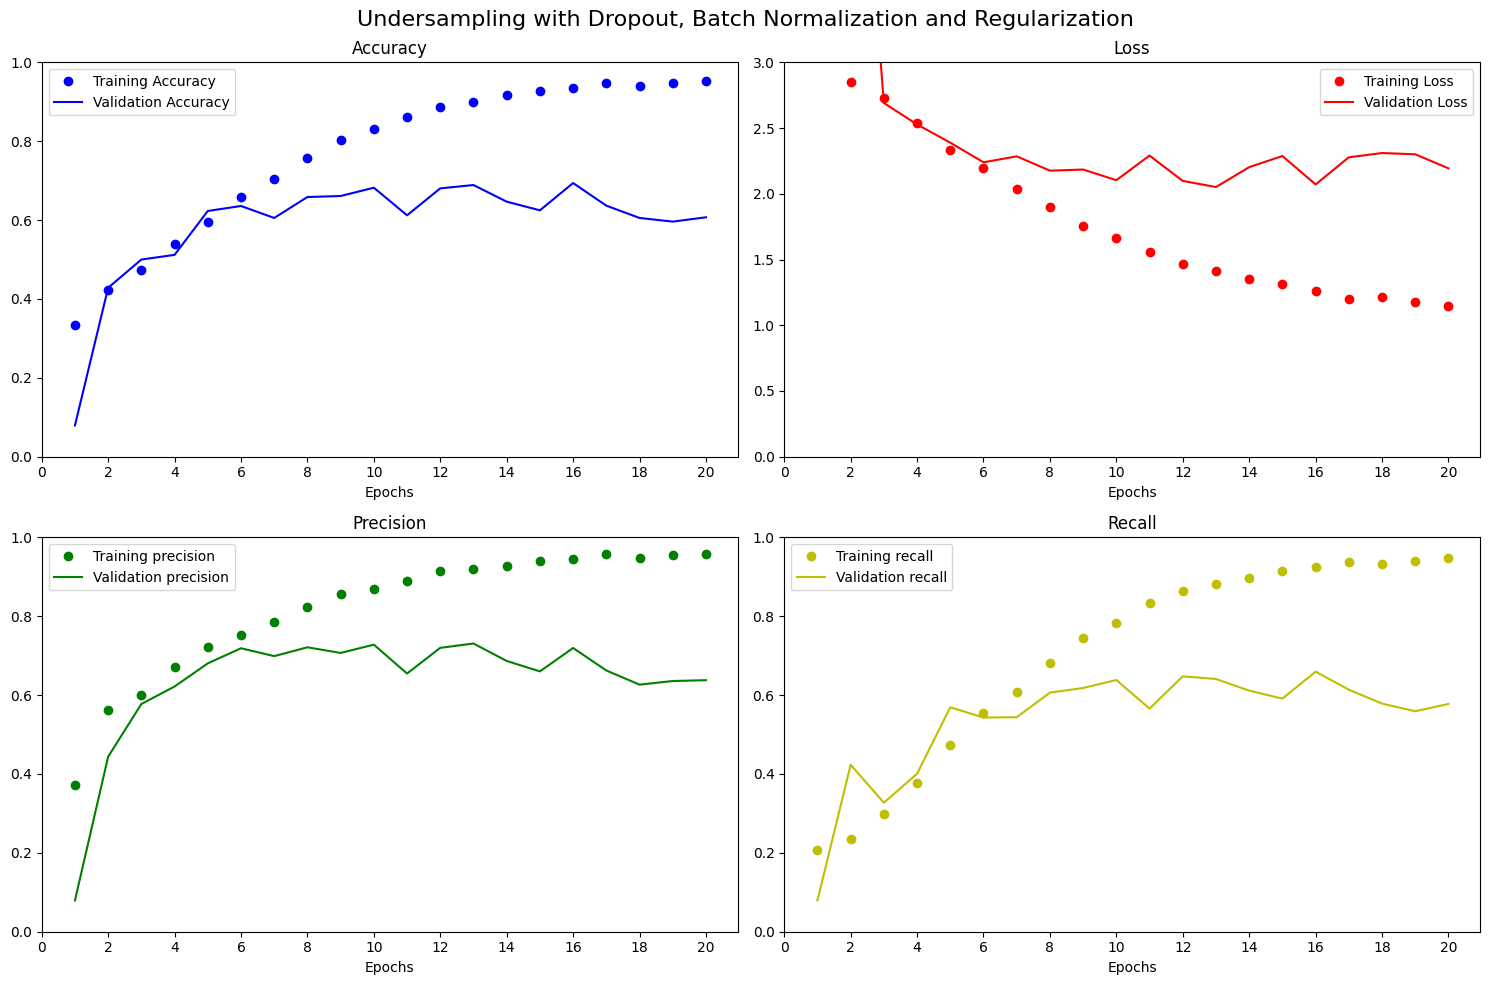

In [246]:
fig, axes = plt.subplots (nrows = 2, ncols = 2, figsize = (15,10))

axes[0,0].plot (epochs_under_dr, accuracy_under_dr, 'bo', label = 'Training Accuracy')
axes[0,0].plot (epochs_under_dr, val_acc_under_dr, 'b', label = 'Validation Accuracy')
axes[0,0].set_title ('Accuracy')
axes[0,0].set_xlabel ('Epochs')
axes[0,0].set_xticks (range(0, len(accuracy_under_dr)+1, 2))
axes[0,0].set_ylim(0,1)
axes[0,0].legend()

axes[0,1].plot (epochs_under_dr, loss_under_dr, 'ro', label = 'Training Loss')
axes[0,1].plot (epochs_under_dr, val_loss_under_dr, 'r', label = 'Validation Loss')
axes[0,1].set_title ('Loss')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_xticks (range(0, len(accuracy_under_dr)+1, 2))
axes[0,1].set_ylim(0,3)
axes[0,1].legend()

axes[1,0].plot (epochs_under_dr, precision_under_dr, 'go', label = 'Training precision')
axes[1,0].plot (epochs_under_dr, val_precision_under_dr, 'g', label = 'Validation precision')
axes[1,0].set_title ('Precision')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_xticks (range(0, len(accuracy_under_dr)+1, 2))
axes[1,0].set_ylim(0,1)
axes[1,0].legend()

axes[1,1].plot (epochs_under_dr, recall_under_dr, 'yo',  label = 'Training recall')
axes[1,1].plot (epochs_under_dr, val_recall_under_dr, 'y',  label = 'Validation recall')
axes[1,1].set_title ('Recall')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_xticks (range(0, len(accuracy_under_dr)+1, 2))
axes[1,1].set_ylim(0,1)
axes[1,1].legend()


fig.suptitle('Undersampling with Dropout, Batch Normalization and Regularization', fontsize=16)
plt.tight_layout()
plt.show()

In [247]:
fig.savefig("Under with Drop, BN and L2 Reg.png", dpi=300, bbox_inches='tight')

Best Performing Model so far. Model is capable of detecting patterns, shapes and general info, showed by the improving on training data. Generalization could be improved despite the fact that the netwrok contains dropout, batch normalization and L2 Regularization.

Next step will be to try the same topology, but with Data Augmentation.

In [235]:
model_u_dr_au= models.Sequential()
model_u_dr_au.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model_u_dr_au.add(layers.BatchNormalization())
model_u_dr_au.add(layers.MaxPooling2D(2,2))
model_u_dr_au.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr_au.add(layers.BatchNormalization())
model_u_dr_au.add(layers.MaxPooling2D(2,2))
model_u_dr_au.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr_au.add(layers.BatchNormalization())
model_u_dr_au.add(layers.MaxPooling2D(2,2))
model_u_dr_au.add(layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model_u_dr_au.add(layers.BatchNormalization())
model_u_dr_au.add(layers.MaxPooling2D(2,2))
model_u_dr_au.add(layers.Dropout(0.25))
model_u_dr_au.add(layers.Flatten())
model_u_dr_au.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_u_dr_au.add(layers.Dropout(0.5))
model_u_dr_au.add(layers.Dense(8, activation='softmax'))

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [236]:
model_u_dr_au.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc'])

In [237]:
train_datagen_u_au = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [238]:
train_dir_u = r'..\Multi_Class_Classification\multi_class_undersampling\train'
train_generator_u_au = train_datagen_u_au.flow_from_directory( 
    train_dir_u,         
    target_size=(224,224), 
    batch_size=20,  
    class_mode='categorical')

Found 3830 images belonging to 8 classes.


In [239]:
callbacks_u_dr_au = [
    EarlyStopping(monitor='val_accuracy', mode= 'max', patience=5, restore_best_weights=True), 
    ModelCheckpoint('Multi_Class_Classification/models/model_u_dr_au.h5', save_best_only=True)]

In [240]:
history_under_dr_au = model_u_dr_au.fit(
    train_generator_u_au,          
    validation_data=val_generator_u,
    epochs=20,                
    steps_per_epoch=len(train_generator_u_au),
    validation_steps=len(val_generator_u), 
    callbacks=callbacks_u_dr_au)

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2700 - auc: 0.6602 - loss: 4.9941 - precision: 0.2932 - recall: 0.1978

192/192 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.3162 - auc: 0.7079 - loss: 3.8439 - precision: 0.3632 - recall: 0.1809 - val_accuracy: 0.0793 - val_auc: 0.4739 - val_loss: 18.9343 - val_precision: 0.0793 - val_recall: 0.0793
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3657 - auc: 0.7898 - loss: 2.9764 - precision: 0.5505 - recall: 0.1798

192/192 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.3470 - auc: 0.7864 - loss: 2.9874 - precision: 0.5156 - recall: 0.1637 - val_accuracy: 0.1315 - val_auc: 0.5727 - val_loss: 10.4274 - val_precision: 0.1271 - val_recall: 0.1239
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3903 - auc: 0.8139 - loss: 2.8939 - precision: 0.5408 - recall: 0.1854

192/192 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.3867 - auc: 0.8104 - loss: 2.8982 - precision: 0.5426 - recall: 0.1864 - val_accuracy: 0.4233 - val_auc: 0.8300 - val_loss: 2.8852 - val_precision: 0.4929 - val_recall: 0.2352
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3888 - auc: 0.8185 - loss: 2.8515 - precision: 0.5603 - recall: 0.1973

192/192 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.3966 - auc: 0.8212 - loss: 2.8255 - precision: 0.5563 - recall: 0.1948 - val_accuracy: 0.4536 - val_auc: 0.8514 - val_loss: 2.6720 - val_precision: 0.5929 - val_recall: 0.2690
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4199 - auc: 0.8312 - loss: 2.7801 - precision: 0.5767 - recall: 0.2277

192/192 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4232 - auc: 0.8314 - loss: 2.7745 - precision: 0.5726 - recall: 0.2214 - val_accuracy: 0.5894 - val_auc: 0.8999 - val_loss: 2.4173 - val_precision: 0.6863 - val_recall: 0.4427
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4310 - auc: 0.8363 - loss: 2.7436 - precision: 0.5944 - recall: 0.2365

192/192 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.4292 - auc: 0.8361 - loss: 2.7342 - precision: 0.5955 - recall: 0.2264 - val_accuracy: 0.5624 - val_auc: 0.9076 - val_loss: 2.3463 - val_precision: 0.7197 - val_recall: 0.4157
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.4491 - auc: 0.8526 - loss: 2.6359 - precision: 0.6065 - recall: 0.2520 - val_accuracy: 0.5034 - val_auc: 0.8767 - val_loss: 2.5126 - val_precision: 0.6302 - val_recall: 0.3550
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.4648 - auc: 0.8588 - loss: 2.5779 - precision: 0.6163 - recall: 0.2671 - val_accuracy: 0.5034 - val_auc: 0.8853 - val_loss: 2.4185 - val_precision: 0.6908 - val_recall: 0.3373
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4825 - auc: 0.8652 - loss: 2.5301 - precision: 0.6440 - recall: 0.2994

192/192 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.4747 - auc: 0.8653 - loss: 2.5352 - precision: 0.6250 - recall: 0.2859 - val_accuracy: 0.5616 - val_auc: 0.9107 - val_loss: 2.2615 - val_precision: 0.7537 - val_recall: 0.3457
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.4888 - auc: 0.8704 - loss: 2.4783 - precision: 0.6236 - recall: 0.3010 - val_accuracy: 0.5944 - val_auc: 0.9070 - val_loss: 2.2923 - val_precision: 0.6857 - val_recall: 0.4949
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.5029 - auc: 0.8749 - loss: 2.4330 - precision: 0.6317 - recall: 0.3131 - val_accuracy: 0.5101 - val_auc: 0.8701 - val_loss: 2.4849 - val_precision: 0.6104 - val_recall: 0.3845
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4915 - auc: 0.8756 - loss: 2.4050 - precision: 0.6281 - recall: 0.3178

192/192 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.5031 - auc: 0.8809 - loss: 2.3710 - precision: 0.6423 - recall: 0.3305 - val_accuracy: 0.6029 - val_auc: 0.9266 - val_loss: 2.0737 - val_precision: 0.7354 - val_recall: 0.4570
Epoch 13/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5232 - auc: 0.8870 - loss: 2.3190 - precision: 0.6579 - recall: 0.3431

192/192 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.5162 - auc: 0.8869 - loss: 2.3119 - precision: 0.6490 - recall: 0.3462 - val_accuracy: 0.6012 - val_auc: 0.9268 - val_loss: 2.0480 - val_precision: 0.6881 - val_recall: 0.4519
Epoch 14/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.5305 - auc: 0.8916 - loss: 2.2597 - precision: 0.6509 - recall: 0.3554 - val_accuracy: 0.6037 - val_auc: 0.9215 - val_loss: 2.0831 - val_precision: 0.6698 - val_recall: 0.5337
Epoch 15/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.5397 - auc: 0.8937 - loss: 2.2191 - precision: 0.6581 - recall: 0.3533 - val_accuracy: 0.4511 - val_auc: 0.8749 - val_loss: 2.3113 - val_precision: 0.5591 - val_recall: 0.3069
Epoch 16/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5405 - auc: 0.8937 - loss: 2.1958 - precision: 0.6696 - recall: 0.3585

192/192 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.5496 - auc: 0.8994 - loss: 2.1554 - precision: 0.6687 - recall: 0.3783 - val_accuracy: 0.6450 - val_auc: 0.9349 - val_loss: 1.9284 - val_precision: 0.6997 - val_recall: 0.5776
Epoch 17/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.5687 - auc: 0.9085 - loss: 2.0783 - precision: 0.6838 - recall: 0.4172 - val_accuracy: 0.6180 - val_auc: 0.9184 - val_loss: 2.0638 - val_precision: 0.6698 - val_recall: 0.5388
Epoch 18/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.5700 - auc: 0.9090 - loss: 2.0439 - precision: 0.6785 - recall: 0.4154 - val_accuracy: 0.4148 - val_auc: 0.8068 - val_loss: 2.9695 - val_precision: 0.4492 - val_recall: 0.3575
Epoch 19/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5663 - auc: 0.9077 - loss: 2.0472 - precision: 0.6816 - recall: 0.4224

192/192 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.5728 - auc: 0.9103 - loss: 2.0172 - precision: 0.6895 - recall: 0.4204 - val_accuracy: 0.6484 - val_auc: 0.9370 - val_loss: 1.8270 - val_precision: 0.6999 - val_recall: 0.5919
Epoch 20/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.5849 - auc: 0.9149 - loss: 1.9573 - precision: 0.6917 - recall: 0.4258 - val_accuracy: 0.5708 - val_auc: 0.9021 - val_loss: 2.0841 - val_precision: 0.6275 - val_recall: 0.4815


In [248]:
accuracy_under_dr_au = history_under_dr_au.history['accuracy']
val_acc_under_dr_au = history_under_dr_au.history ['val_accuracy']

loss_under_dr_au = history_under_dr_au.history['loss']
val_loss_under_dr_au = history_under_dr_au.history['val_loss']

precision_under_dr_au = history_under_dr_au.history['precision']
val_precision_under_dr_au = history_under_dr_au.history['val_precision']

recall_under_dr_au = history_under_dr_au.history['recall']
val_recall_under_dr_au = history_under_dr_au.history['val_recall']

epochs_under_dr_au = range(1, len(accuracy_under_dr_au)+1)

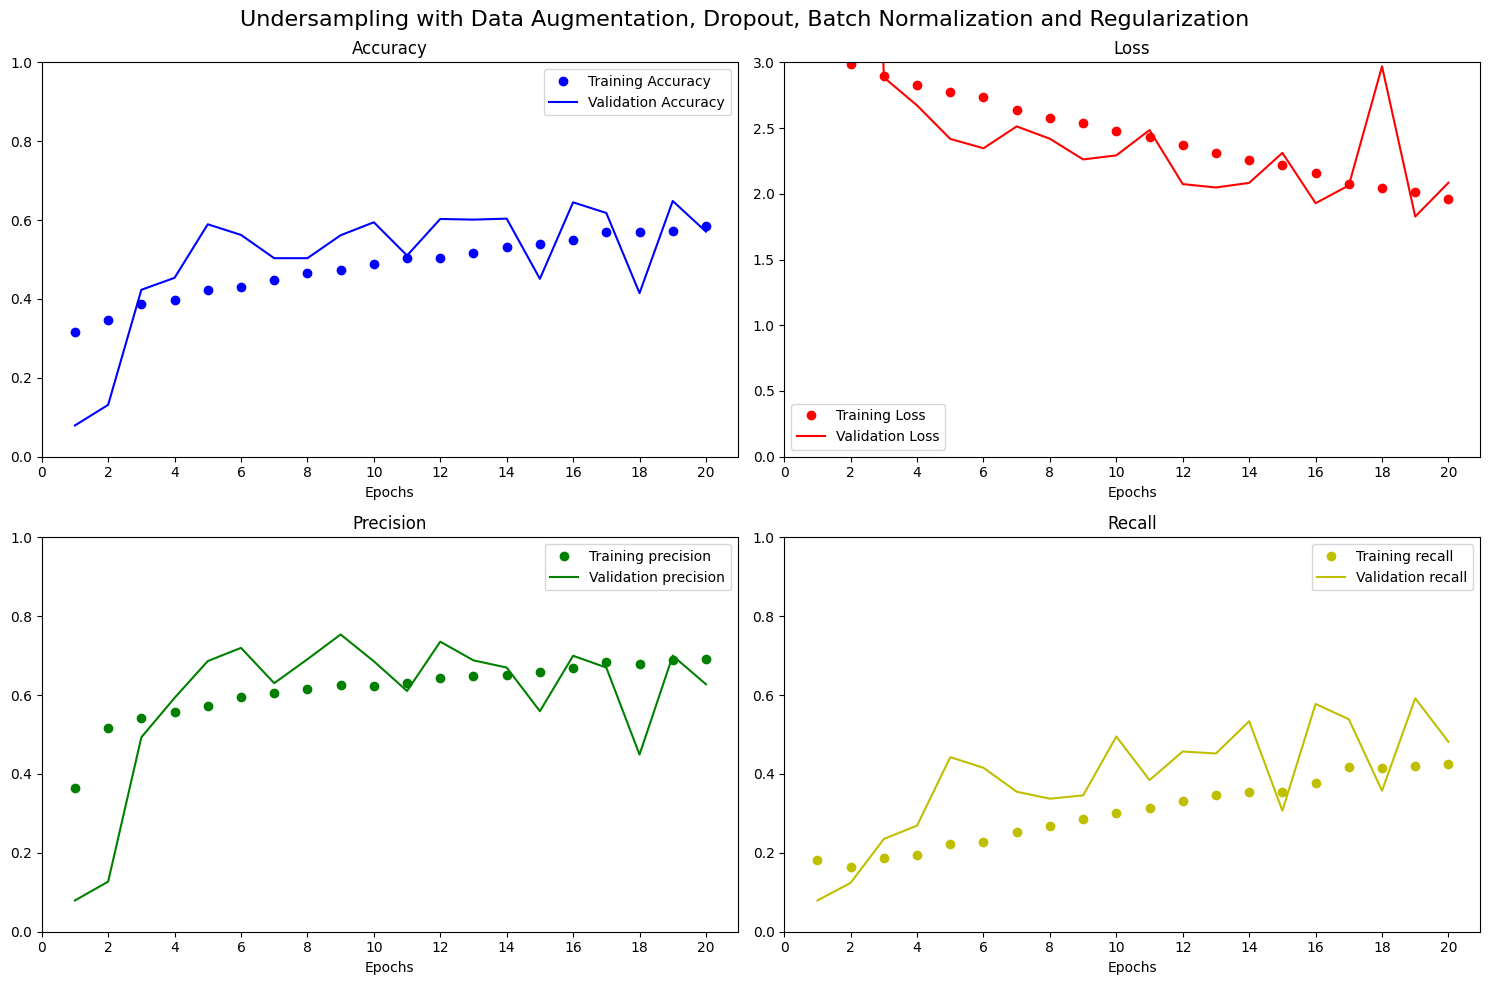

In [249]:
fig, axes = plt.subplots (nrows = 2, ncols = 2, figsize = (15,10))

axes[0,0].plot (epochs_under_dr_au, accuracy_under_dr_au, 'bo', label = 'Training Accuracy')
axes[0,0].plot (epochs_under_dr_au, val_acc_under_dr_au, 'b', label = 'Validation Accuracy')
axes[0,0].set_title ('Accuracy')
axes[0,0].set_xlabel ('Epochs')
axes[0,0].set_xticks (range(0, len(accuracy_under_dr_au)+1, 2))
axes[0,0].set_ylim(0,1)
axes[0,0].legend()

axes[0,1].plot (epochs_under_dr_au, loss_under_dr_au, 'ro', label = 'Training Loss')
axes[0,1].plot (epochs_under_dr_au, val_loss_under_dr_au, 'r', label = 'Validation Loss')
axes[0,1].set_title ('Loss')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_xticks (range(0, len(accuracy_under_dr_au)+1, 2))
axes[0,1].set_ylim(0,3)
axes[0,1].legend()

axes[1,0].plot (epochs_under_dr_au, precision_under_dr_au, 'go', label = 'Training precision')
axes[1,0].plot (epochs_under_dr_au, val_precision_under_dr_au, 'g', label = 'Validation precision')
axes[1,0].set_title ('Precision')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_xticks (range(0, len(accuracy_under_dr_au)+1, 2))
axes[1,0].set_ylim(0,1)
axes[1,0].legend()

axes[1,1].plot (epochs_under_dr_au, recall_under_dr_au, 'yo',  label = 'Training recall')
axes[1,1].plot (epochs_under_dr_au, val_recall_under_dr_au, 'y',  label = 'Validation recall')
axes[1,1].set_title ('Recall')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_xticks (range(0, len(accuracy_under_dr_au)+1, 2))
axes[1,1].set_ylim(0,1)
axes[1,1].legend()


fig.suptitle('Undersampling with Data Augmentation, Dropout, Batch Normalization and Regularization', fontsize=16)
plt.tight_layout()
plt.show()

In [250]:
fig.savefig("Under with Data Augm, Drop, BN and L2 Reg.png", dpi=300, bbox_inches='tight')